### Reading in Color Images

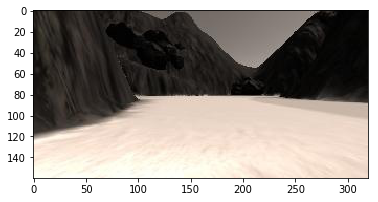

In [2]:
#has to be before import
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

filename = "sample.jpg"
image = mpimg.imread(filename)
plt.imshow(image)
plt.show()

#### Masks Test

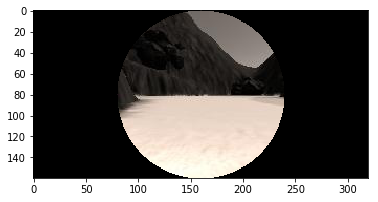

In [25]:
#Don't run this part of code normally
nrows, ncols, nlayers = image.shape
row, col = np.ogrid[:nrows, :ncols]
cnt_row, cnt_col = nrows / 2, ncols / 2
outer_disk_mask = ((row - cnt_row)**2 + (col - cnt_col)**2 > (nrows / 2)**2)
image[outer_disk_mask] = 0
plt.imshow(image)
plt.show()

In [26]:
print(image.dtype, image.shape, np.min(image), np.max(image))

uint8 (160, 320, 3) 0 255


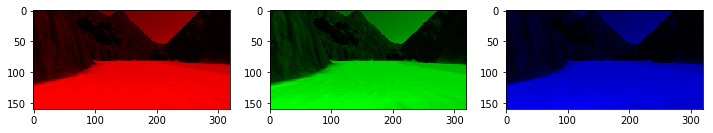

In [29]:
# Note: we use the np.copy() function rather than just saying red_channel = image
# because in Python, such a statement would set those two arrays equal to each other
# forever, meaning any changes made to one would also be made to the other!
red_channel = np.copy(image)
# Note: here instead of extracting individual channels from the image
# I'll keep all 3 color channels in each case but set the ones I'm not interested 
# in to zero.  
red_channel[:,:,[1, 2]] = 0 # Zero out the green and blue channels
green_channel = np.copy(image)
green_channel[:,:,[0, 2]] = 0 # Zero out the red and blue channels
blue_channel = np.copy(image)
blue_channel[:,:,[0, 1]] = 0 # Zero out the red and green channels
fig = plt.figure(figsize=(12,3)) # Create a figure for plotting
plt.subplot(131) # Initialize subplot number 1 in a figure that is 3 columns 1 row
plt.imshow(red_channel) # Plot the red channel
plt.subplot(132) # Initialize subplot number 2 in a figure that is 3 columns 1 row
plt.imshow(green_channel)  # Plot the green channel
plt.subplot(133) # Initialize subplot number 3 in a figure that is 3 columns 1 row
plt.imshow(blue_channel)  # Plot the blue channel
plt.show() 

### Color Thresholding

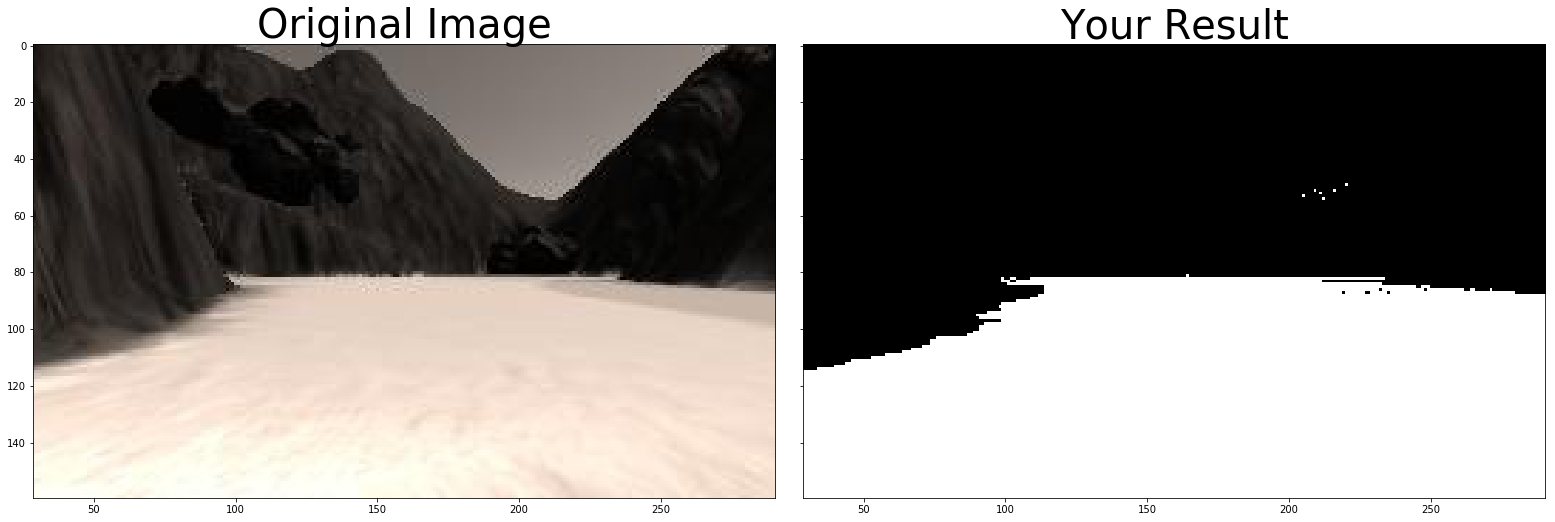

In [9]:
# Define a function to perform a color threshold
def color_thresh(img, rgb_thresh=(0, 0, 0)):
    ###### TODO:
    # Create an empty array the same size in x and y as the image 
    # but just a single channel
    color_select = np.zeros_like(img[:,:,0])
    # Apply the thresholds for RGB and assign 1's 
    # where threshold was exceeded
    # Return the single-channel binary image
    thresh = (img[:,:,0] > rgb_thresh[0]) \
            & (img[:,:,1] > rgb_thresh[1]) \
            & (img[:,:,2] > rgb_thresh[2])
    color_select[thresh] = 1
    return color_select
    
# Define color selection criteria
###### TODO: MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
red_threshold = 160
green_threshold = 160
blue_threshold = 160
######
rgb_threshold = (red_threshold, green_threshold, blue_threshold)

# pixels below the thresholds
colorsel = color_thresh(image, rgb_thresh=rgb_threshold)

# Display the original image and binary               
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 7), sharey=True)
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(colorsel, cmap='gray')
ax2.set_title('Your Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()